# Camera

## Location

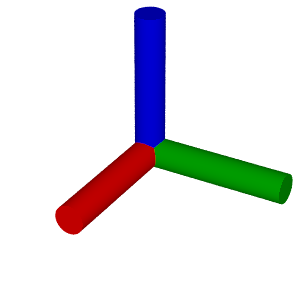

In [1]:
from fdray import *

Scene(
    Camera(longitude=30, latitude=30),
    LightSource(0, Color("white")),  # at camera location
    Cylinder(0, (1, 0, 0), 0.1, Color("red")),
    Cylinder(0, (0, 1, 0), 0.1, Color("green")),
    Cylinder(0, (0, 0, 1), 0.1, Color("blue")),
).render(width=300, height=300)

The camera implementation is based on the following Qiita article

 - Title: Efficient Camera Settings in POV-Ray
 - Author: @Hyrodium (Yuto Horikawa)
 - URL: https://qiita.com/Hyrodium/items/af91b1ddb8ea2c4359c2
 - Date: 2017-12-07

We adopt the spherical coordinate system for camera positioning
and the calculation methods for direction, right, and up vectors.

## Orbital Location

Calculate a position in orbit around the camera's location

Imagine tilting your head up (`angle`) and then rotating
counter-clockwise (`rotation`):

- First, move `forward` along viewing direction (0: at `camera.location`,
  1: at `camera.look_at`). Negative values move behind the camera.
- Then, tilt up from viewing direction by `angle` degrees
- Finally, rotate counter-clockwise from up by `rotation` degrees
    (0: up, 90: left, 180: down, 270: right)

In [2]:
def render(camera: Camera, *args):
    return Scene(
        camera,
        LightSource(0, "white"),
        Cylinder(0, "2*x", 0.02, Color("red")),
        Cylinder(0, "2*y", 0.02, Color("green")),
        Cylinder(0, "2*z", 0.02, Color("blue")),
        *args,
    ).render(width=400, height=400)

<0, 0, 2>
<0, 2, 0>


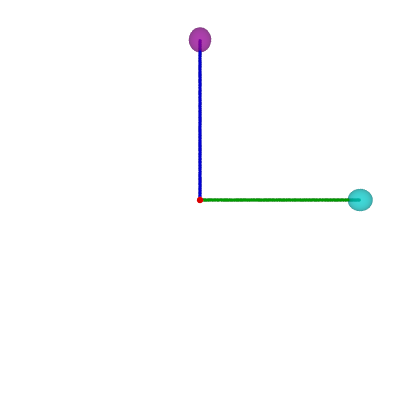

In [25]:
from math import asin, degrees, sqrt

distance = 4
camera = Camera(0, 0, view_scale=2.5, look_at=(0, 0, 0), distance=distance)
norm = sqrt(distance**2 + 2**2)
angle = degrees(asin(2 / norm))
p = camera.orbital_location(norm / distance, angle)
print(p)
s1 = Sphere(p, 0.14, Color("purple", 0.5))
p = camera.orbital_location(norm / distance, angle, -90)
print(p)
s2 = Sphere(p, 0.14, Color("cyan", 0.5))
render(camera, s1, s2)

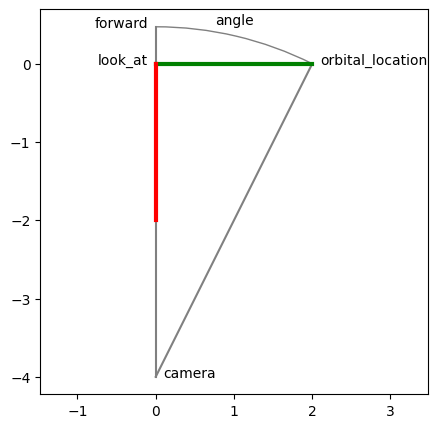

In [73]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot([2, 0], [0, -distance], c="gray")
ax.plot([0, 0], [-distance, -distance + norm], c="gray")
ax.add_patch(
    Arc(
        (0, -distance),
        2 * norm,
        2 * norm,
        theta1=90 - angle,
        theta2=90,
        color="gray",
    ),
)
ax.plot([0, 2], [0, 0], c="green", lw=3)
ax.plot([0, 0], [0, -2], c="red", lw=3)
ax.text(0.1, -distance, "camera")
ax.text(-0.1, 0, "look_at", ha="right")
ax.text(2.1, 0, "orbital_location")
ax.text(-0.1, -distance + norm, "forward", ha="right")
ax.text(1, 0.5, "angle", ha="center")
ax.axis("equal");